In [2]:
# Generate 5 images with ./data/test_prompts.json
import os, json, torch
from diffusers import StableDiffusionPipeline
device = "cuda"

OUT_DIR = './outputs/diffusion_tests'
os.makedirs(OUT_DIR, exist_ok=True)

with open('./data/test_prompts.json', 'r', encoding='utf-8') as f:
    raw = json.load(f)

keys = list(raw.keys())
prompts = [raw[k] for k in keys]

print(prompts)

base_model_path = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path, 
    torch_dtype=torch.float16,
    safety_checker=None,
)
pipe.to(device)

generator = torch.Generator(device=device)
result = pipe(prompt=prompts, num_inference_steps=30, guidance_scale=7.5, generator=generator)
images = result.images

for key, img in zip(keys, images):
    fname = f"{key}_result.png"
    path = os.path.join(OUT_DIR, fname)
    img.save(path)


/home/reproducepark/anaconda3/envs/cs492d/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['pale golden rod circle with old lace background', 'sea green circle with a light cyan background', 'deep sky blue circle with a light yellow background', 'rosy brown circle with a misty rose background', 'forest green circle with an antique brown background']


Loading pipeline components...:  17%|█▋        | 1/6 [00:00<00:01,  3.57it/s]/home/reproducepark/anaconda3/envs/cs492d/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.97it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in

0 : pale golden rod circle with old lace background
1 : sea green circle with a light cyan background
2 : deep sky blue circle with a light yellow background
3 : rosy brown circle with a misty rose background
4 : forest green circle with an antique brown background


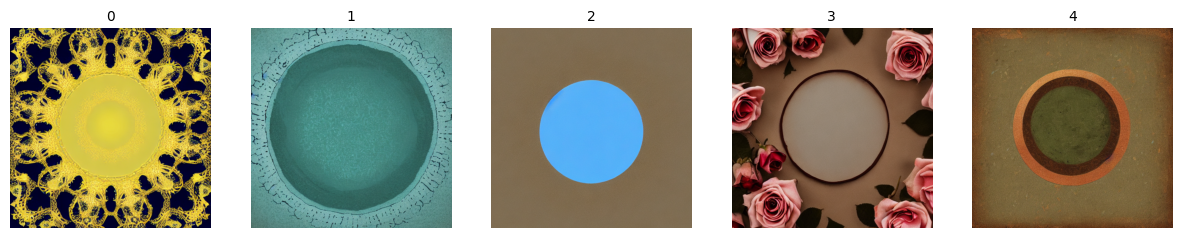

In [7]:
# Show 5 images with prompts
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, (key, img) in enumerate(zip(keys, images)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(key, fontsize=10, pad=5)

for k in keys:
    print(k+ " : "+ raw[k])

In [ ]:
# Generate 25 ControlNet images for prompt-condition pairs
from diffusion.controlnet import ControlNetModel
from diffusion.pipeline_controlnet import StableDiffusionControlNetPipeline
from diffusers import UniPCMultistepScheduler
from diffusers.utils import load_image

CONTROL_OUT_DIR = "./outputs/controlnet_tests"
os.makedirs(CONTROL_OUT_DIR, exist_ok=True)

controlnet_ckpt = "./runs/controlnet_fill50k"

# from inference.ipynb
controlnet = ControlNetModel.from_pretrained(
    controlnet_ckpt,
    torch_dtype=torch.float16,
)
control_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    torch_dtype=torch.float16,
    safety_checker=None,
)
control_pipe.scheduler = UniPCMultistepScheduler.from_config(control_pipe.scheduler.config)
control_pipe.to(device)

condition_dir = "./data/test_conditions"


def _condition_sort_key(name: str):
    stem = os.path.splitext(name)[0]
    return int(stem) if stem.isdigit() else stem


condition_files = [
        fname
        for fname in os.listdir(condition_dir)
    ]

grid_results = []

for cond_idx, fname in enumerate(condition_files):
    control_image = load_image(os.path.join(condition_dir, fname))

    row_entries = []

    row_entries.append(
        {
            "condition_file": fname,
            "prompt_key": "original",
            "prompt": "original",
            "image": control_image,
        }
    )

    for prompt_idx, (prompt_key, prompt_text) in enumerate(zip(keys, prompts)):
        generator = torch.Generator(device=device)
        output = control_pipe(
            prompt_text,
            num_inference_steps=30,
            guidance_scale=7.5,
            generator=generator,
            image=control_image,
        )
        image = output.images[0]
        save_name = f"c{os.path.splitext(fname)[0]}_p{prompt_key}_result.png"
        image.save(os.path.join(CONTROL_OUT_DIR, save_name))
        row_entries.append(
            {
                "condition_file": fname,
                "prompt_key": prompt_key,
                "prompt": prompt_text,
                "image": image,
            }
        )
    grid_results.append(row_entries)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]/home/reproducepark/anaconda3/envs/cs492d/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  5.31it/s]
You have disabled the safety checker for <class 'diffusion.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstance

0 : pale golden rod circle with old lace background
1 : sea green circle with a light cyan background
2 : deep sky blue circle with a light yellow background
3 : rosy brown circle with a misty rose background
4 : forest green circle with an antique brown background


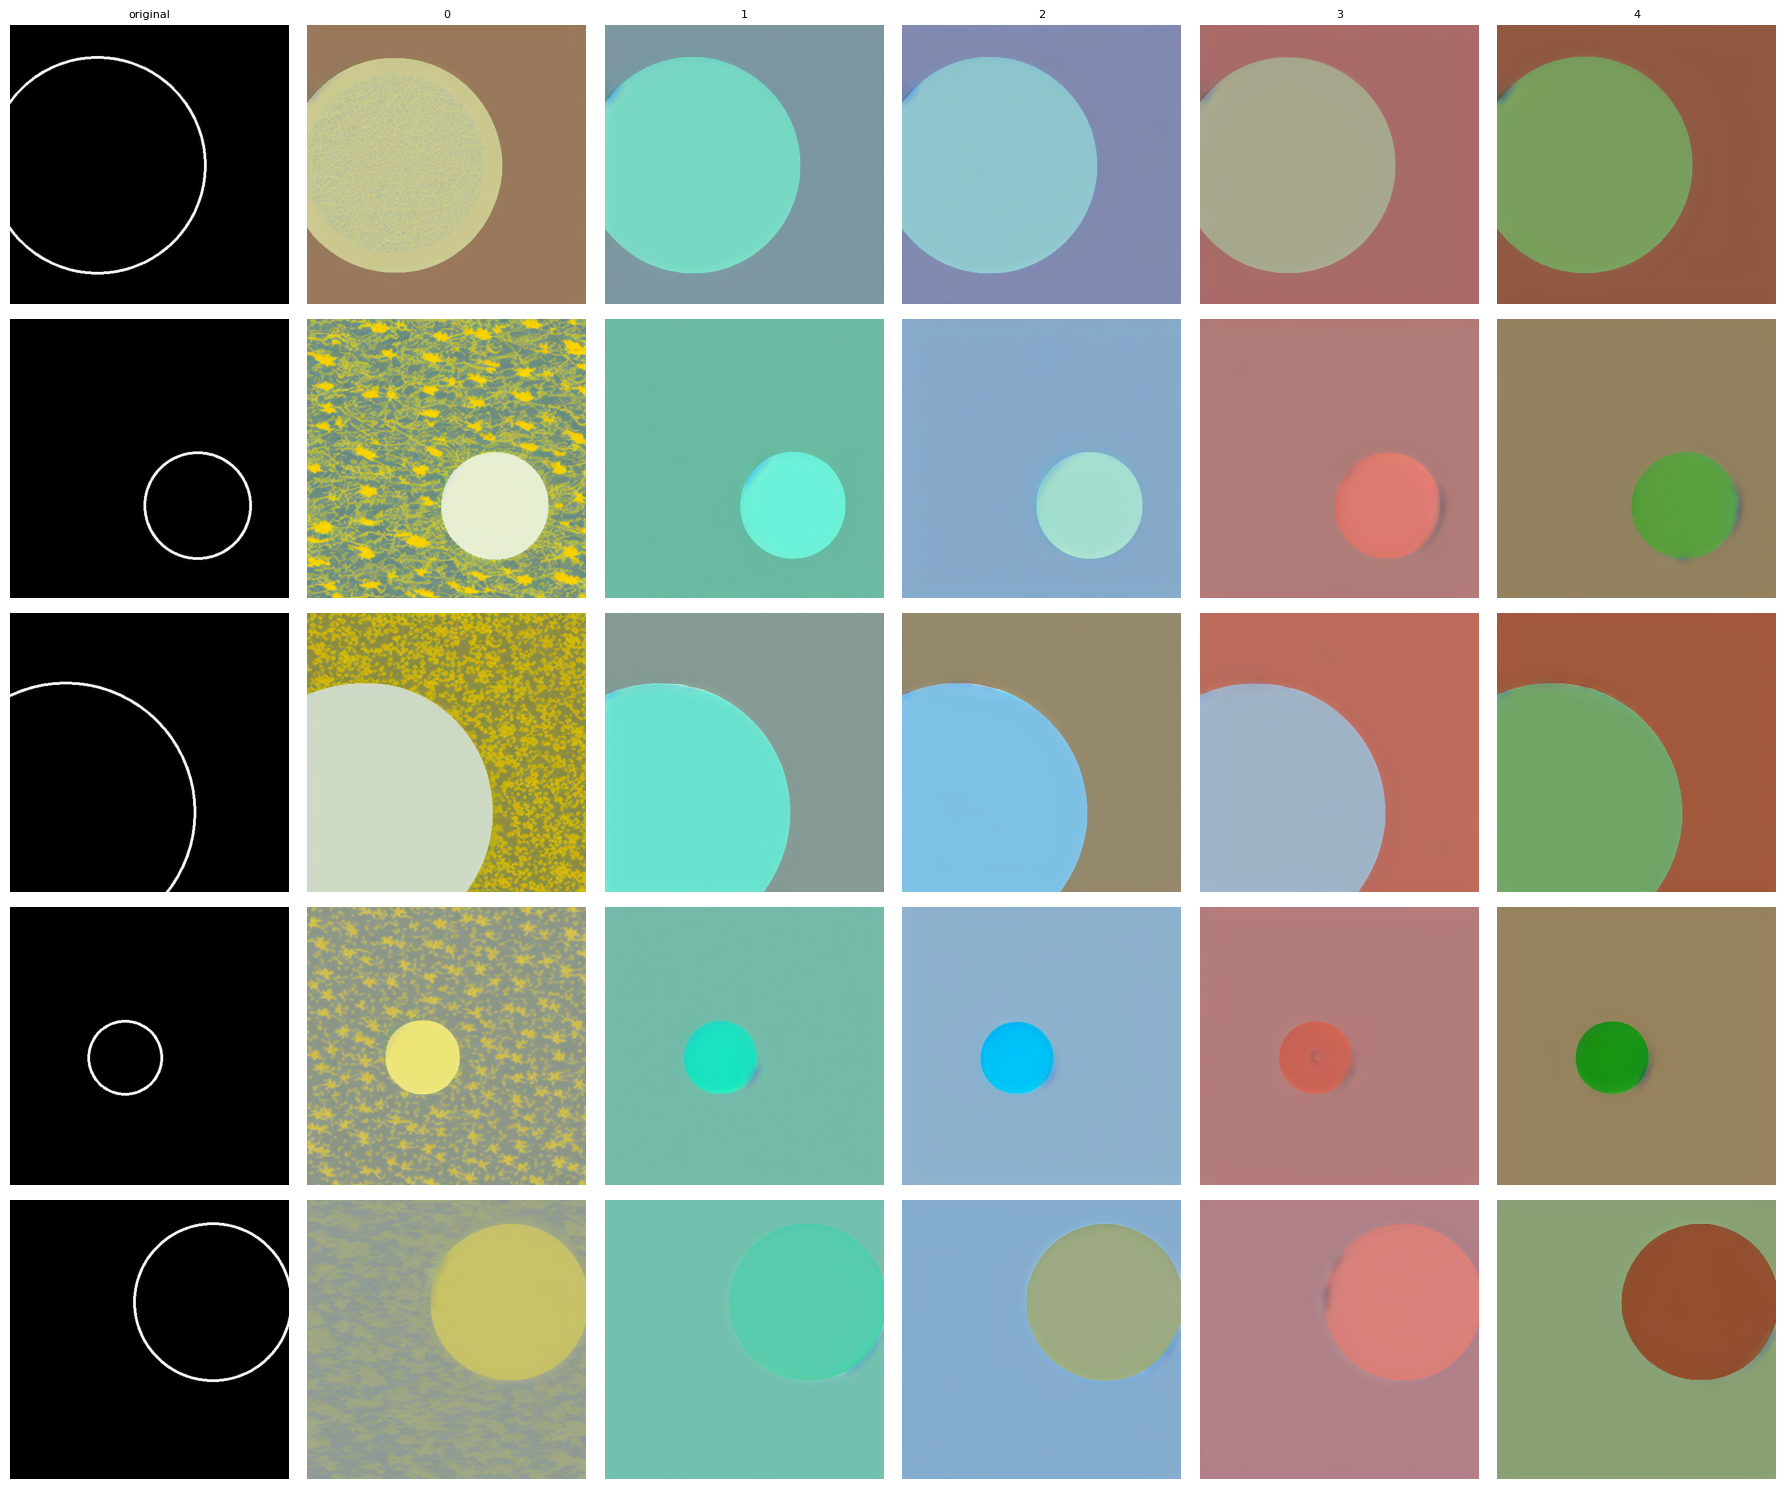

In [10]:
# Show 5 images for each condition with prompts
num_conditions = len(grid_results)
num_prompts = len(grid_results[0])

fig, axes = plt.subplots(num_conditions, num_prompts, figsize=(3 * num_prompts, 3 * num_conditions))

for k in keys:
    print(k+ " : "+ raw[k])

for row_idx in range(num_conditions):
    for col_idx in range(num_prompts):
        ax = axes[row_idx, col_idx]
        entry = grid_results[row_idx][col_idx]
        ax.imshow(entry["image"])
        ax.axis("off")
        if row_idx == 0:
            ax.set_title(f"{entry['prompt_key']}", fontsize=8)
        if col_idx == 0:
            ax.set_ylabel(f"cond {entry['condition_file']}", rotation=0, labelpad=40, fontsize=8)

plt.tight_layout()
plt.show()
